# Datos perdidos y datos anomalos.

Empecemos por importar las librerias que vamos a usar.

In [1]:
!pip install missingno
!pip install ydata_profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 69.0 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=abdebb357085890568b75dfd02c5eff19adde690bb54a7a7fd0968f49f498ef8
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [67]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import ipywidgets as widgets
from IPython.display import display
from sklearn.experimental import enable_iterative_imputer  # Necesario para activar IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from ydata_profiling import ProfileReport

Importamos nuestro archivo como dataframe, y visualizamoss las columnas de nuestro dataframe.

In [116]:
df = pd.read_csv('enco_processed_tidy.csv', low_memory=False)
df.columns

Index(['fol', 'ent', 'con', 'v_sel', 'n_hog', 'h_mud', 'i_per', 'ing', 'mpio',
       'ageb', 'fch_def', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9',
       'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'year'],
      dtype='object')

Convertiremos los tipos de datos a los adecuados, como las columnas que contienen respuestas a las preguntas del cuestionario básico y las fechas.

In [117]:
# Lista de columnas a convertir
columns_to_convert = [f'p{i}' for i in range(1, 16)]

# Convierte las columnas a tipo 'category'
df[columns_to_convert] = df[columns_to_convert].astype('category')
df['v_sel'] = df['v_sel'].astype('category')
df['h_mud'] = df['h_mud'].astype('category')
df['fch_def'] = pd.to_datetime(df['fch_def'], errors='coerce', format='mixed')
df['i_per'] = df['i_per'].astype('category')
df.dtypes

,0
fol,object
ent,int64
con,int64
v_sel,category
n_hog,int64
h_mud,category
i_per,category
ing,float64
mpio,int64
ageb,object


nombre de las entidades.......................

In [118]:
state_codes = {
    1: 'AGUASCALIENTES', 2: 'BAJA CALIFORNIA', 3: 'BAJA CALIFORNIA SUR', 4: 'CAMPECHE',
    5: 'COAHUILA DE ZARAGOZA', 6: 'COLIMA', 7: 'CHIAPAS', 8: 'CHIHUAHUA', 9: 'DISTRITO FEDERAL',
    10: 'DURANGO', 11: 'GUANAJUATO', 12: 'GUERRERO', 13: 'HIDALGO', 14: 'JALISCO', 15: 'MEXICO',
    16: 'MICHOACAN DE OCAMPO', 17: 'MORELOS', 18: 'NAYARIT', 19: 'NUEVO LEON', 20: 'OAXACA',
    21: 'PUEBLA', 22: 'QUERETARO DE ARTEAGA', 23: 'QUINTANA ROO', 24: 'SAN LUIS POTOSI', 25: 'SINALOA',
    26: 'SONORA', 27: 'TABASCO', 28: 'TAMAULIPAS', 29: 'TLAXCALA', 30: 'VERACRUZ DE IGNACIO DE LA LLAVE',
    31: 'YUCATAN', 32: 'ZACATECAS'
}

# Map 'entidad' in the data to state names
df['estado'] = df['ent'].map(state_codes)
df.head()

,fol,ent,con,v_sel,n_hog,h_mud,i_per,ing,mpio,ageb,...,p8,p9,p10,p11,p12,p13,p14,p15,year,estado
0,11B167,1,40006,3,1,0,1.0,1300.0,5,025-1,...,3,2,2,3,6,3,3,1,2018,AGUASCALIENTES
1,11B167,1,40006,3,1,0,NaN,NaN,5,025-1,...,3,2,2,3,6,3,3,1,2018,AGUASCALIENTES
2,11B167,1,40006,3,1,0,NaN,NaN,5,025-1,...,3,2,2,3,6,3,3,1,2018,AGUASCALIENTES
3,11B167,1,40006,3,1,0,NaN,NaN,5,025-1,...,3,2,2,3,6,3,3,1,2018,AGUASCALIENTES
4,11B167,1,40006,3,1,0,1.0,1100.0,5,025-1,...,3,2,2,3,6,3,3,1,2018,AGUASCALIENTES


Vamos a hacer un describe de nuestros datos.

In [119]:
df.describe()

,ent,con,n_hog,ing,mpio,fch_def,year
count,217140.000000,217140.000000,217140.0,91928.000000,217140.000000,217140,217140.000000
mean,15.686824,40295.016086,1.0,384434.426236,41.076932,2020-06-25 19:53:15.733628416,2019.960238
min,1.000000,22251.000000,1.0,25.000000,1.000000,2018-01-03 00:00:00,2018.000000
25%,9.000000,40151.000000,1.0,1500.000000,6.000000,2018-08-11 00:00:00,2018.000000
50%,15.000000,40271.000000,1.0,5000.000000,26.000000,2020-09-03 00:00:00,2020.000000
75%,20.000000,40391.000000,1.0,999999.000000,50.000000,2022-06-04 00:00:00,2022.000000
max,32.000000,41420.000000,1.0,999999.000000,553.000000,2022-12-21 00:00:00,2022.000000
std,7.837322,491.438315,0.0,484181.879242,52.167613,NaN,1.745458


Como se puede observar la columna `ing` tiene anomalías, y lo podemos notar ya que el máximo de la columna es `999999`, por lo que le haremos el tratamiento correspondiente, reemplazandolos pon NaN.

In [120]:
df['ing'] = df['ing'].replace(999999, pd.NA)
df['ing'] = df['ing'].replace(99999, pd.NA)

Por otro lado, haremos el conteo de los valores perdidos;

In [121]:
# Contar los valores perdidos en cada columna
valores_perdidos = df.isna().sum()

# Calcular el porcentaje de datos perdidos para cada columna
porcentaje_perdidos = (valores_perdidos / len(df)) * 100

# Filtrar solo las columnas que tienen datos perdidos y crear un DataFrame
columnas_con_perdidos = pd.DataFrame({
    'Valores Perdidos': valores_perdidos[valores_perdidos > 0],
    'Porcentaje Perdidos': porcentaje_perdidos[valores_perdidos > 0].map("{:.2f}%".format)
})

print("Columnas con datos perdidos:")
print(columnas_con_perdidos)

Columnas con datos perdidos:
       Valores Perdidos Porcentaje Perdidos
i_per             44941              20.70%
ing              160346              73.84%


Puesto que tenemos variables categóricas, veremos cuantas "claves" hay para cada columna.

In [122]:
valores_unicos = df.nunique().to_frame(name='Valores Únicos').T # Contar valores únicos en cada columna
valores_unicos

,fol,ent,con,v_sel,n_hog,h_mud,i_per,ing,mpio,ageb,...,p8,p9,p10,p11,p12,p13,p14,p15,year,estado
Valores Únicos,219,32,815,4,1,4,11,388,91,3235,...,4,3,4,6,7,6,4,4,3,32


Llama la atención en particular la columna `i_per`, ya que en el [diccionario](https://github.com/INEQMX-ENCO/INEQMX-ENCO-2022/blob/main/references/Diccionario_ENCO_2022.md) tenemos 5 valores posibles, pero nos resultan 11, por lo que arreglaremos eso.


Primero hagamos algunas graficas que nos ayuden a visulizar nuestro escenario en las columnas `i_per` e `ing`. Además de observar que valores hay en `i_per` y por qué hay más de las que esperabamos.

In [123]:
df['i_per'].unique()

['1.0', NaN, '2.0', '3.0', '5.0', ..., ' ', '1', '5', '3', '4']
Length: 12
Categories (11, object): [' ', '1', '1.0', '2', ..., '4', '4.0', '5', '5.0']

Como podemos observar los valores de las claves se están repitiendo, es por eso que tenemos más 'claves' de las que deberíamos tener. Así que arreglaremos eso haciendo lo siguiente;

In [124]:
# Eliminar los espacios vacíos y convertir todos los valores a cadenas
df['i_per'] = df['i_per'].replace(' ', 'NaN')  # Reemplazar espacios vacíos por NaN
df['i_per'] = df['i_per'].astype(str).replace({'nan': 'NaN'})  # Convertir todo a cadena, manejando los NaN

# Convertir los valores numéricos a formato consistente (por ejemplo, como enteros)
df['i_per'] = df['i_per'].apply(lambda x: str(int(float(x))) if x not in ['NaN', ''] else 'NaN')

# Ahora puedes obtener los valores únicos sin repeticiones
df['i_per'].unique()

<ipython-input-124-eceee90e80f0>:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['i_per'] = df['i_per'].replace(' ', 'NaN')  # Reemplazar espacios vacíos por NaN


array(['1', 'NaN', '2', '3', '5', '4'], dtype=object)

Observemos el boxplot de la columna `ing`, que presenta una gran cantidad de valores perdidos. Esto hace que su análisis visual sea particularmente interesante.

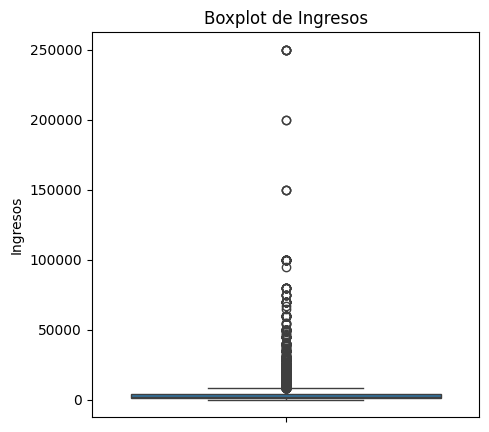

In [125]:
plt.figure(figsize=(5, 5))
sns.boxplot(y=df['ing'])
plt.title('Boxplot de Ingresos')
plt.ylabel('Ingresos')
plt.show()

Como podemos observar, la caja es muy pequeña en comparación con la escala total de los datos. Esto sugiere que el 50% central de los datos está muy concentrado en valores bajos, mientras que una minoría de valores extremos eleva considerablemente el rango total de ingresos.

Veamos ahora la distribución de las respuestas a cada una de las preguntas que se hicieron en el cuestionario para saber su situación económica.

In [126]:
# Diccionario que asocia cada columna con el texto de la pregunta
preguntas = {
    'p1': '¿Cómo describiría usted su situación económica comparada con la de hace 12 meses?',
    'p2': '¿Y cómo cree usted que será su situación económica dentro de 12 meses respecto a la actual?',
    'p3': 'Comparada con la situación económica que los miembros de este hogar tenían hace 12 meses, ¿Cómo cree que que es su situación en este momento?',
    'p4': '¿Cómo considera usted que será la situación económica de los miembros de este hogar dentro de 12 meses, respecto a la actual?',
    'p5': '¿Cómo considera usted la situación económica del país hoy en día comparada con la de hace 12 meses?',
    'p6': '¿Cómo considera usted que será la condición económica del país dentro de 12 meses respecto de la actual situación?',
    'p7': '¿En este momento tiene usted mayores posibilidades de comprar ropa, zapatos, alimentos, etc... que hace un año? ',
    'p8': 'Comparando la situación económica actual con la de hace un año, ¿cómo considera en el momento actual las posibilidades de que usted o alguno de los integrantes de este hogar realice compras tales como muebles, televisor, lavadora, otros aparatos electrodomésticos, etc...?',
    'p9': '¿Considera usted que durante los próximos 12 meses, usted o alguno de los integrantes de este hogar tendrán posibilidades económicas para salir de vacaciones?',
    'p10': '¿Actualmente usted tiene posibilidades de ahorrar alguna parte de sus ingresos?',
    'p11': '¿Cómo considera usted que serán sus condiciones económicas para ahorrar dentro de 12 meses comparadas con las actuales?',
    'p12': 'Comparando con los 12 meses anteriores, ¿cómo cree usted que se comporten los precios en el país en los siguientes 12 meses?',
    'p13': '¿Cómo cree usted que evolucionará el empleo en el país en los próximos 12 meses?',
    'p14': '¿Algún miembro de este hogar o usted están planeando comprar un automóvil nuevo o usado en los próximos 2 años?',
    'p15': '¿Algún miembro de este hogar o usted están planeando comprar, construir o remodelar una casa en los próximos 2 años?'
}

# Función para graficar la variable seleccionada
def graficar_pregunta(variable):
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x=df[variable])
    plt.title(f"Distribución de respuestas para:\n {preguntas[variable]}")
    plt.xlabel("Respuestas")
    plt.ylabel("Frecuencia")

    # Eliminar solo las líneas de los ejes sin afectar los números y etiquetas
    ax.spines['top'].set_visible(False)   # Eliminar borde superior
    ax.spines['right'].set_visible(False) # Eliminar borde derecho
    ax.spines['left'].set_visible(False)  # Eliminar borde izquierdo
    ax.spines['bottom'].set_visible(False) # Eliminar borde inferior

    # Mostrar el gráfico sin los recuadros pero con las leyendas
    plt.show()

# Control de selección
selector = widgets.Dropdown(
    options=preguntas.keys(),
    description='Pregunta:',
    disabled=False
)

# Mostrar el gráfico cuando se selecciona una pregunta
widgets.interactive(lambda variable: graficar_pregunta(variable), variable=selector)

interactive(children=(Dropdown(description='Pregunta:', options=('p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8…

Visualizaremos ahora como se ve el dataframe respecto a los datos faltantes.

<Axes: >

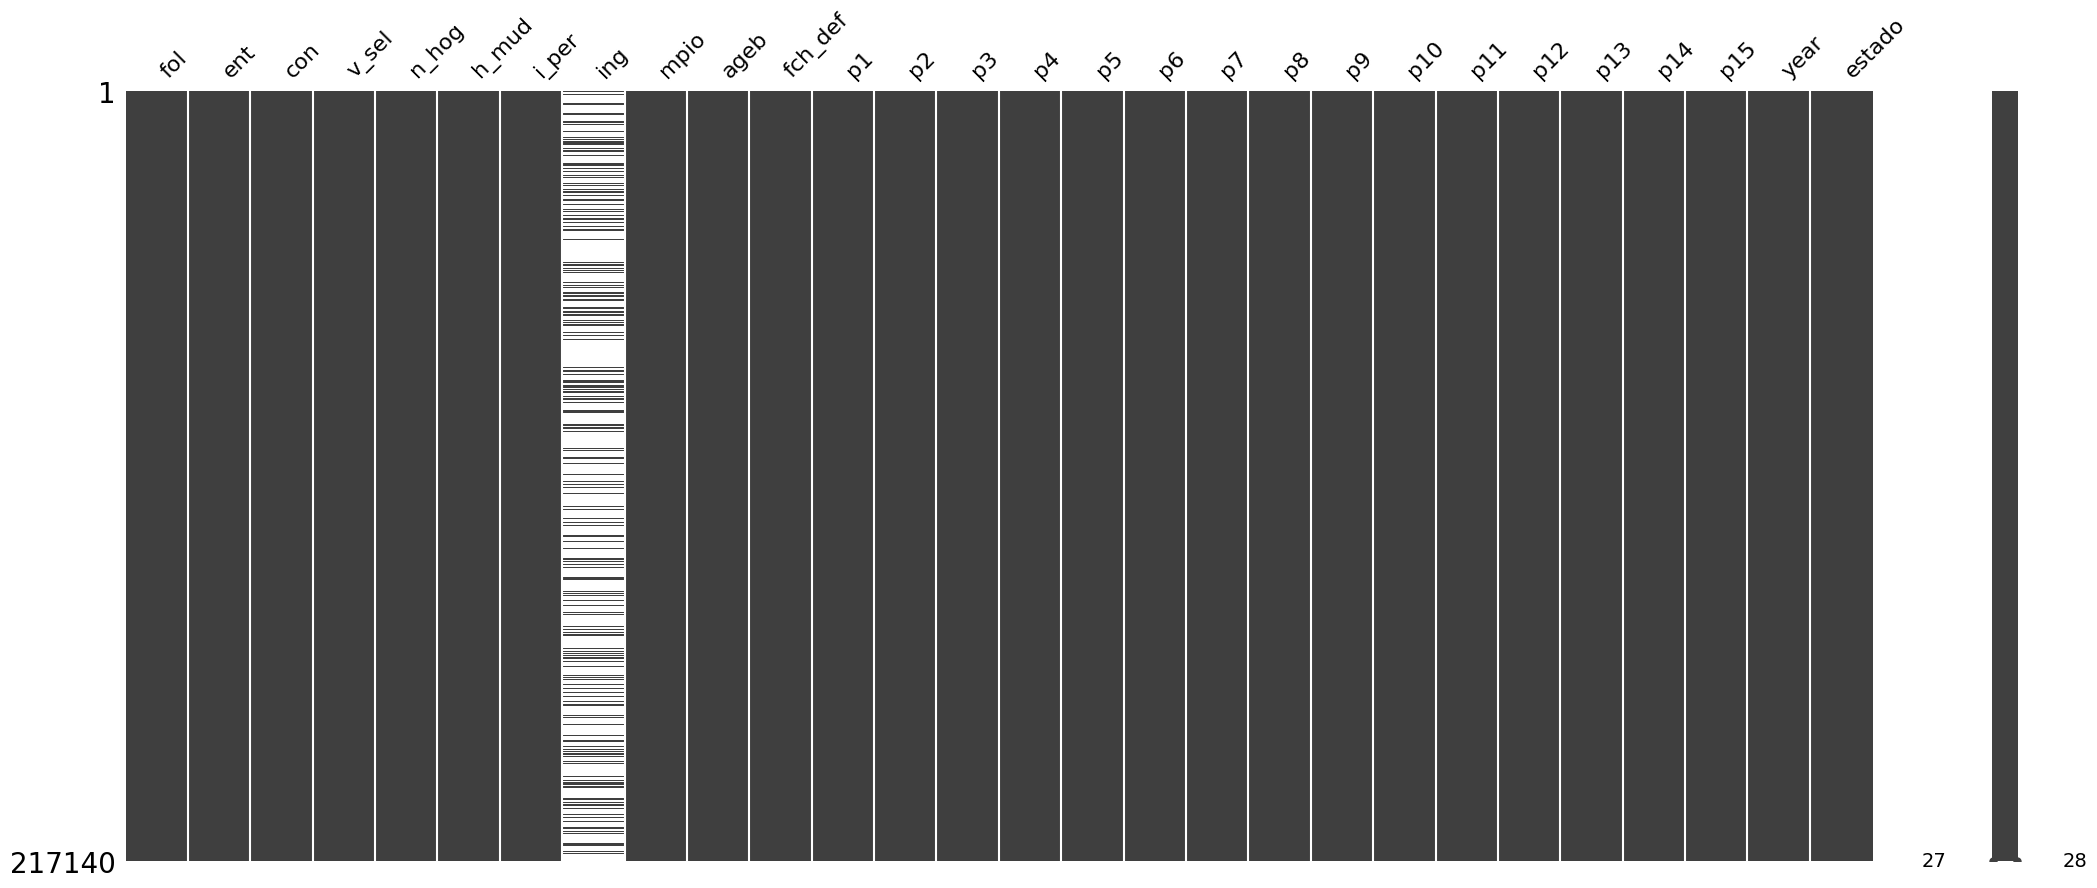

In [127]:
msno.matrix(df)

Por ultimo, veamos un grafico de barras para visualizar que tanto hay datos perdidos en las columnas respecto a otras.

<Axes: >

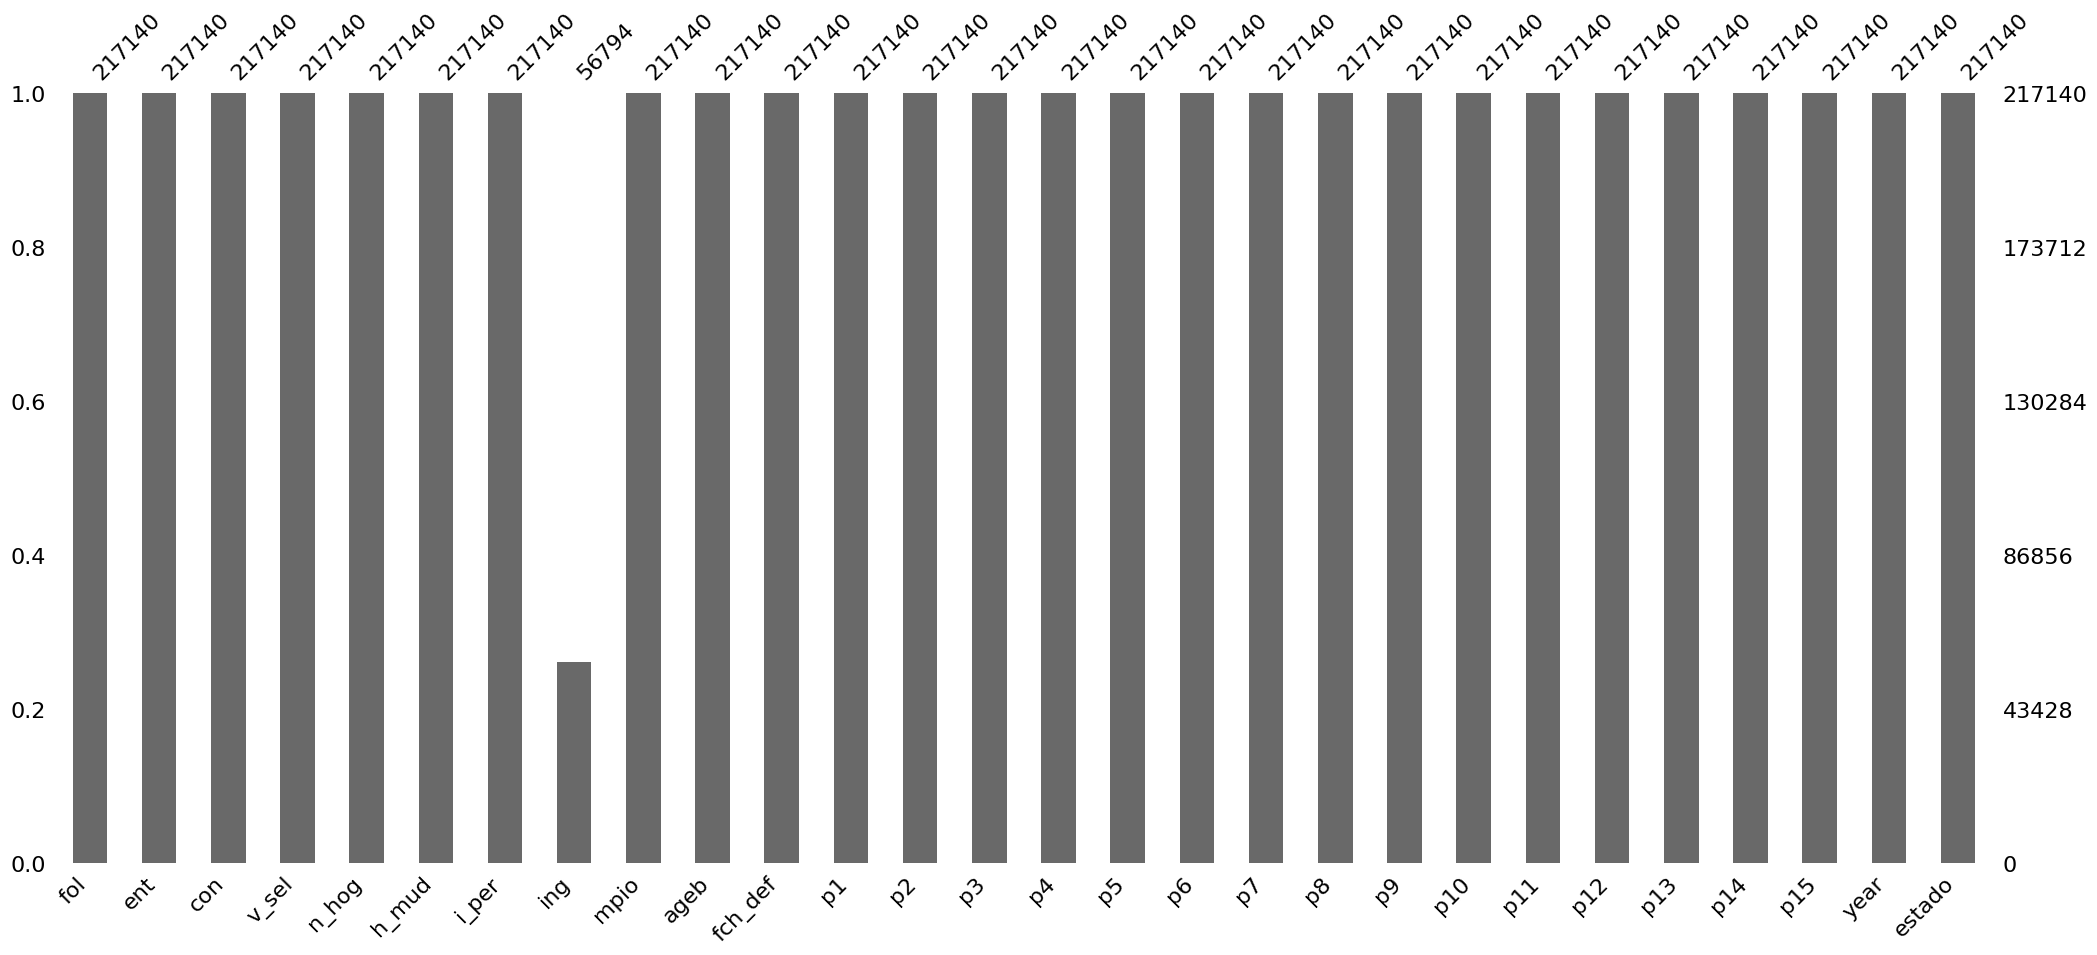

In [128]:
msno.bar(df)

Sin embargo, como ya habíamos visto antes, hay un 73.84% de datos perdidos en `ing` por lo que ya no es conveniente trabajar con ella, es por eso que la eliminaremos de nuestro análisis.

In [129]:
df = df.drop(columns=['ing'])
df = df.dropna()
# Contar los valores perdidos en cada columna
valores_perdidos = df.isna().sum()

# Calcular el porcentaje de datos perdidos para cada columna
porcentaje_perdidos = (valores_perdidos / len(df)) * 100

columnas_con_perdidos = pd.DataFrame({
    'Valores Perdidos': valores_perdidos[valores_perdidos > 0],
    'Porcentaje Perdidos': porcentaje_perdidos[valores_perdidos > 0].map("{:.2f}%".format)
})

print("Columnas con datos perdidos:")
print(columnas_con_perdidos)

Columnas con datos perdidos:
Empty DataFrame
Columns: [Valores Perdidos, Porcentaje Perdidos]
Index: []


<Axes: >

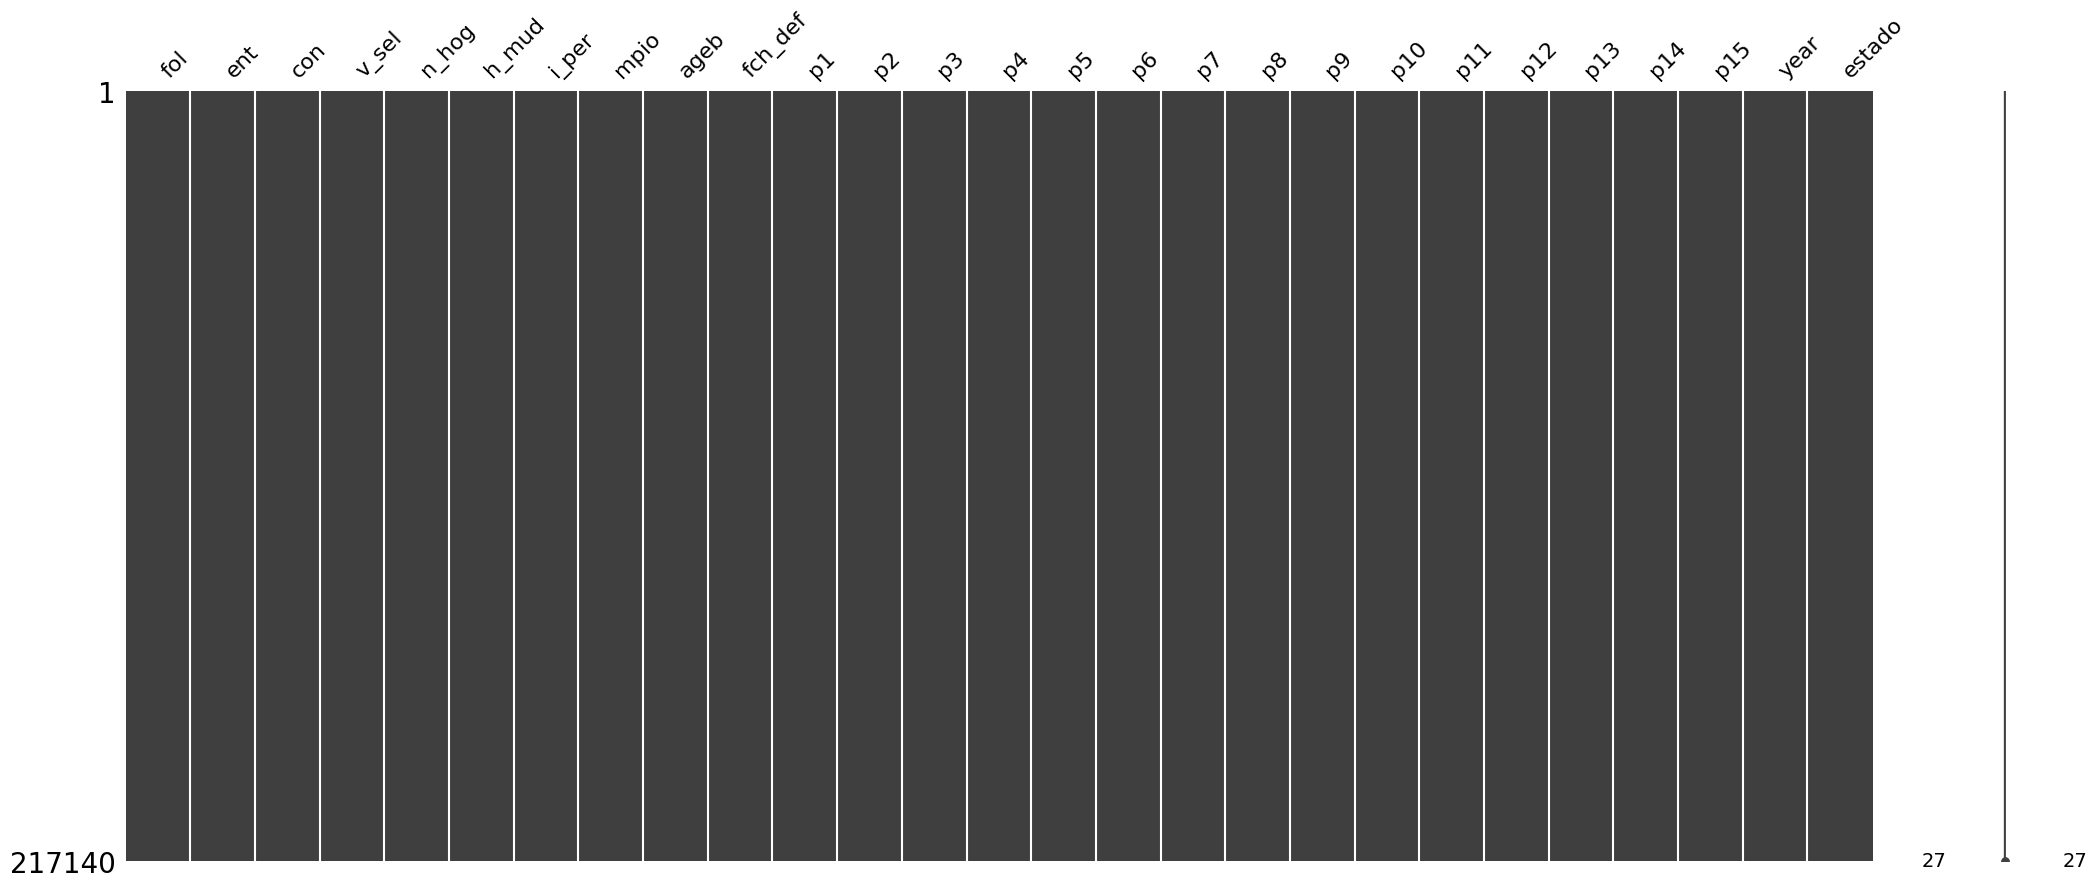

In [130]:
msno.matrix(df)